**Problem Statement**

Forecast the Airlines Passengers data set. Prepare a document for each model explaining 
how many dummy variables you have created and RMSE value for each model. Finally which model you will use for 
Forecasting.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import files
uploaded=files.upload()

Saving Airlines+Data.xlsx to Airlines+Data.xlsx


In [3]:
air=pd.read_excel("Airlines+Data.xlsx")
air

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


In [4]:
air.isna().sum()

Month         0
Passengers    0
dtype: int64

In [5]:
air.duplicated().sum()

0

In [6]:
air.shape

(96, 2)

In [7]:
air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [8]:
air.describe()

,Passengers
count,96.000000
mean,213.708333
std,71.918216
min,104.000000
25%,156.000000
50%,200.000000
75%,264.750000
max,413.000000


**Feature Engineering**

In [9]:
air['month']=air.Month.dt.strftime('%b')
air['year']=air.Month.dt.strftime('%Y')

air['t']=np.arange(1,len(air)+1)
air['t_squared']=np.square(air.t)

air['log_passengers']=np.log(air.Passengers)

In [10]:
air.head()

,Month,Passengers,month,year,t,t_squared,log_passengers
0,1995-01-01,112,Jan,1995,1,1,4.718499
1,1995-02-01,118,Feb,1995,2,4,4.770685
2,1995-03-01,132,Mar,1995,3,9,4.882802
3,1995-04-01,129,Apr,1995,4,16,4.859812
4,1995-05-01,121,May,1995,5,25,4.795791


In [11]:
air1=air[['t','t_squared','month','Passengers','log_passengers']]
air1.head()

,t,t_squared,month,Passengers,log_passengers
0,1,1,Jan,112,4.718499
1,2,4,Feb,118,4.770685
2,3,9,Mar,132,4.882802
3,4,16,Apr,129,4.859812
4,5,25,May,121,4.795791


In [12]:
air1=pd.get_dummies(air1)
air1.head()

,t,t_squared,Passengers,log_passengers,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep
0,1,1,112,4.718499,0,0,0,0,1,0,0,0,0,0,0,0
1,2,4,118,4.770685,0,0,0,1,0,0,0,0,0,0,0,0
2,3,9,132,4.882802,0,0,0,0,0,0,0,1,0,0,0,0
3,4,16,129,4.859812,1,0,0,0,0,0,0,0,0,0,0,0
4,5,25,121,4.795791,0,0,0,0,0,0,0,0,1,0,0,0


**Data Visualisations**

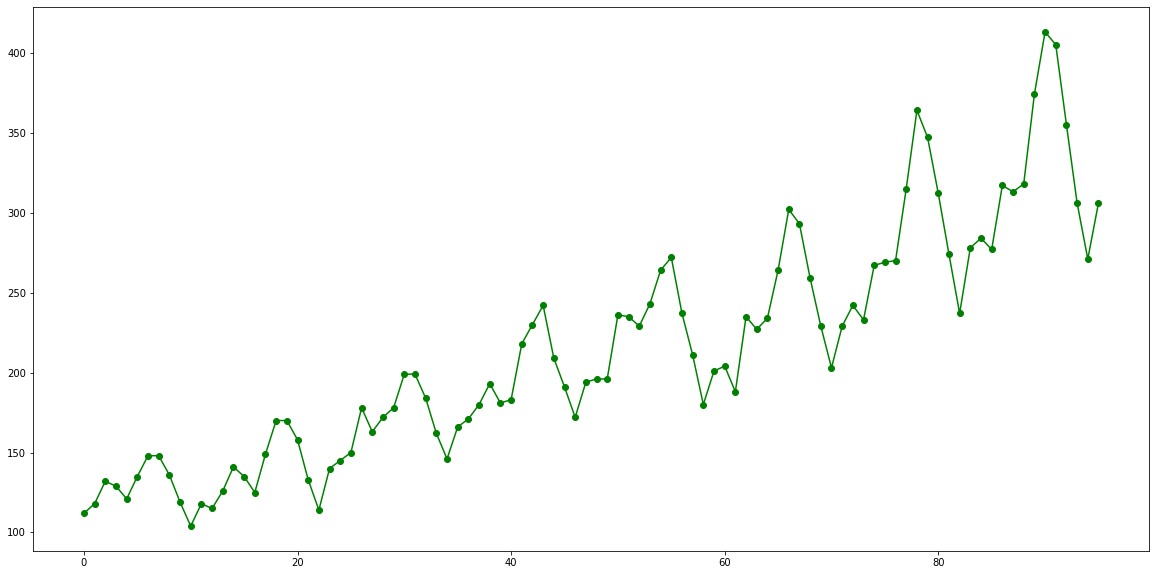

In [13]:
air1['Passengers'].plot(figsize=(20,10),color='green',marker='o');

There is an **increasing trend**.

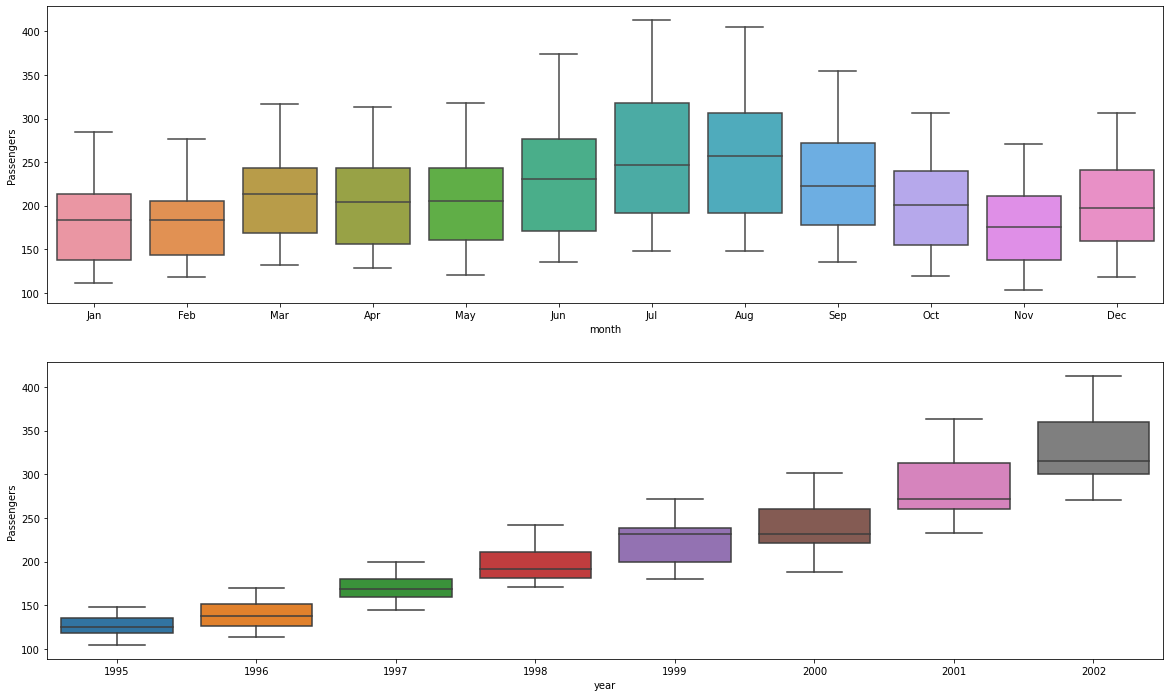

In [14]:
plt.figure(figsize=(20,12))

plt.subplot(2,1,1)
sns.boxplot(air.month,air.Passengers);
plt.subplot(2,1,2)
sns.boxplot(air.year,air.Passengers);

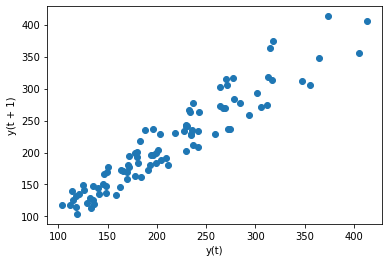

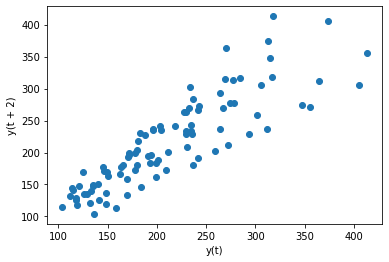

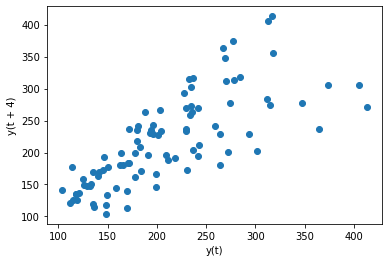

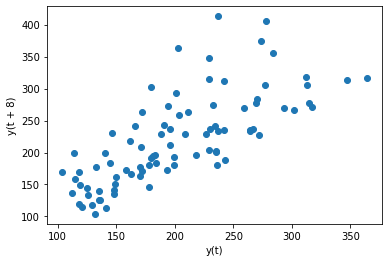

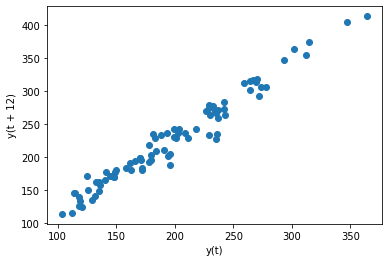

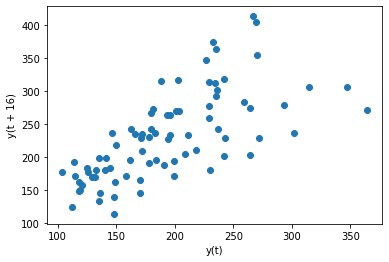

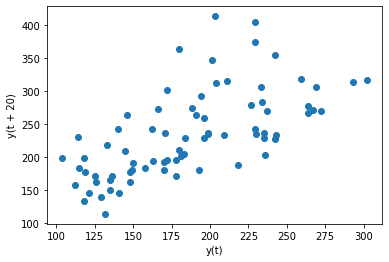

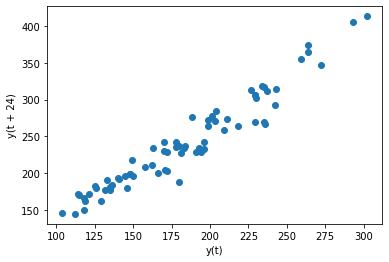

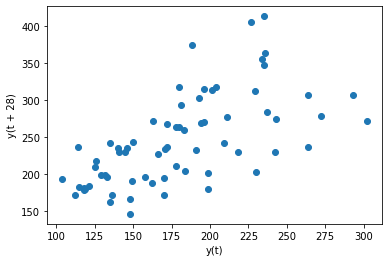

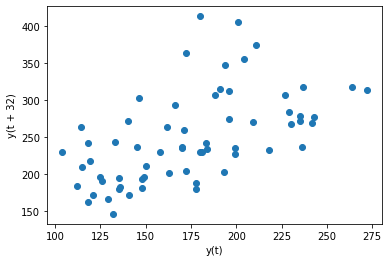

In [15]:
#Lag Plot - Plots variable against it's own lagged samples
from pandas.plotting import lag_plot

for i in [1,2,4,8,12,16,20,24,28,32]:
    lag_plot(air.Passengers,lag=i)
    plt.show()

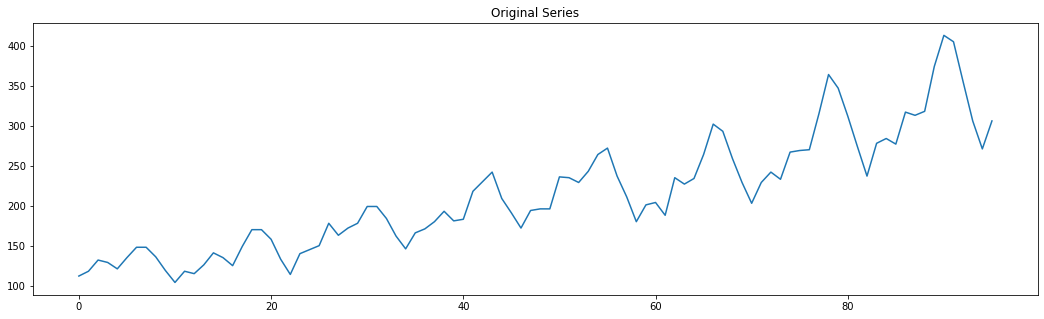

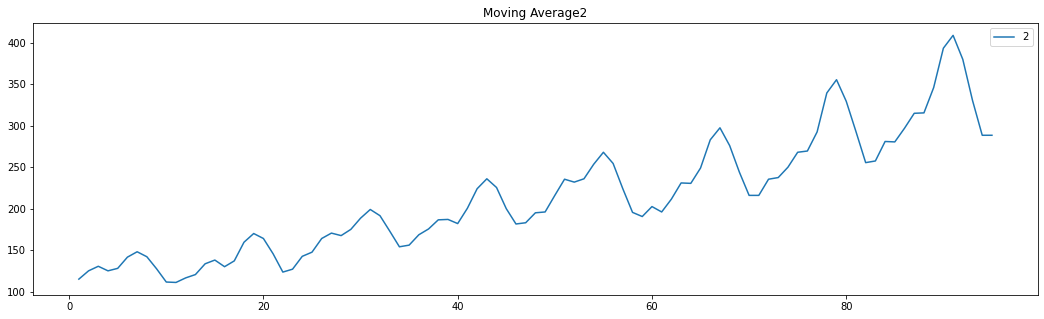

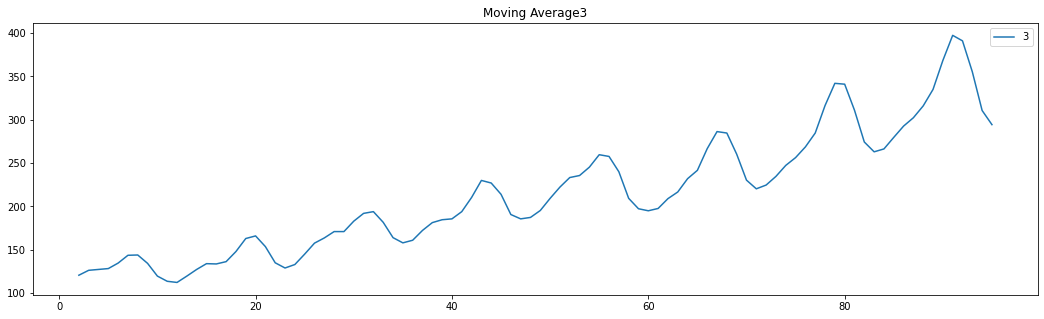

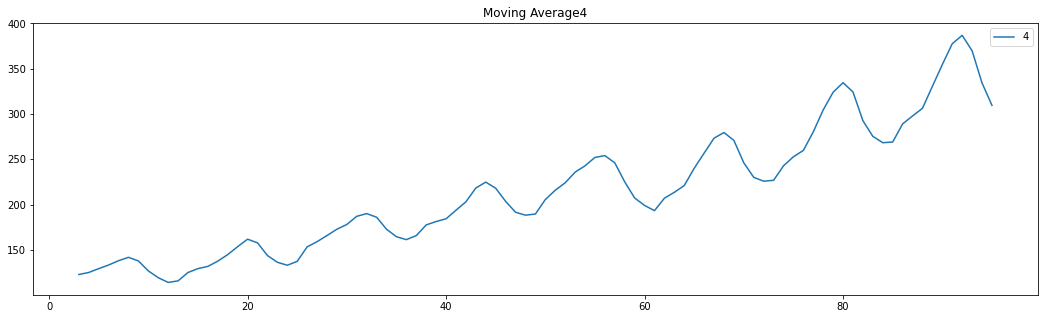

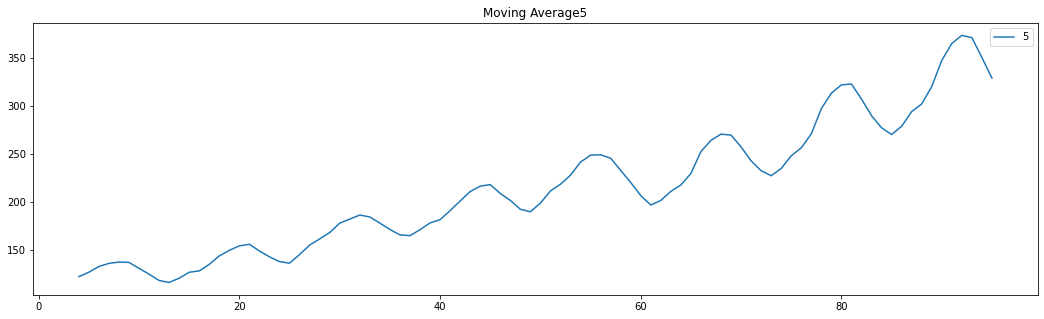

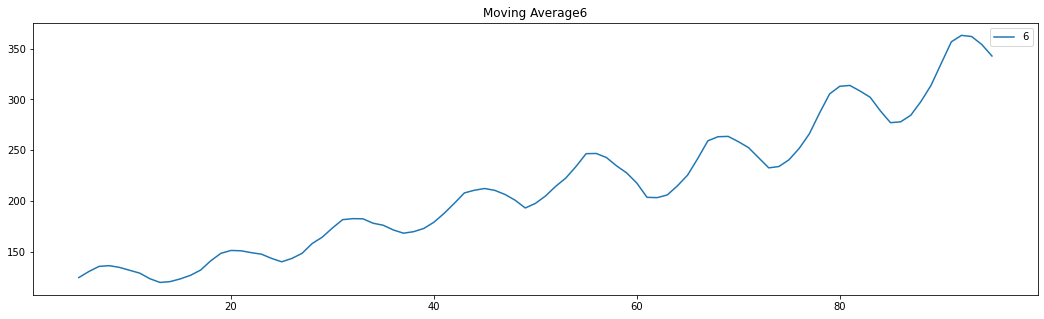

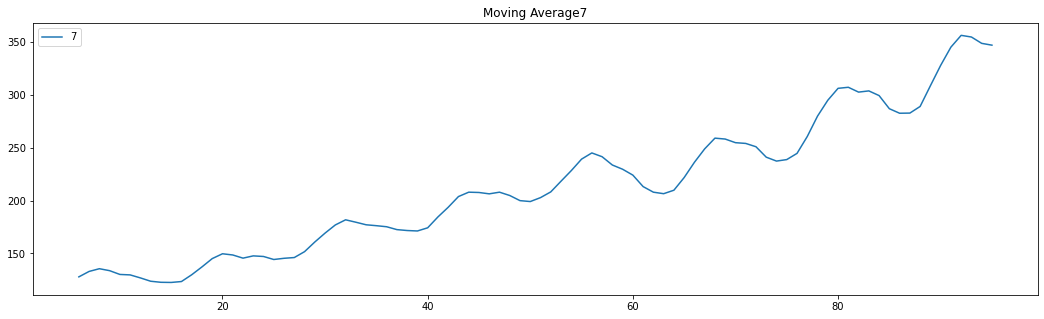

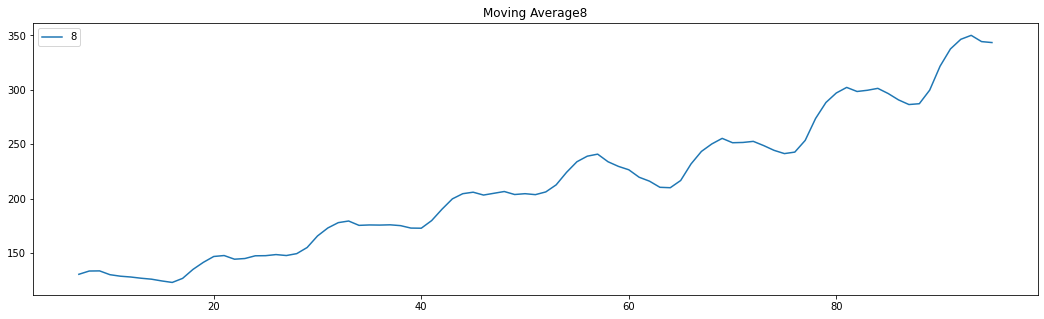

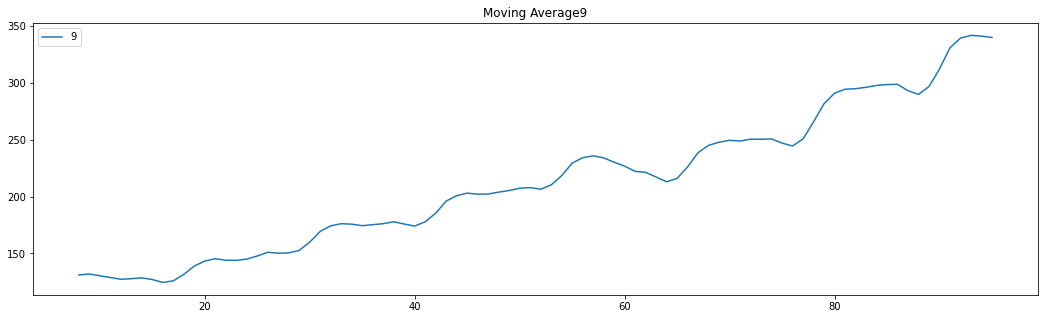

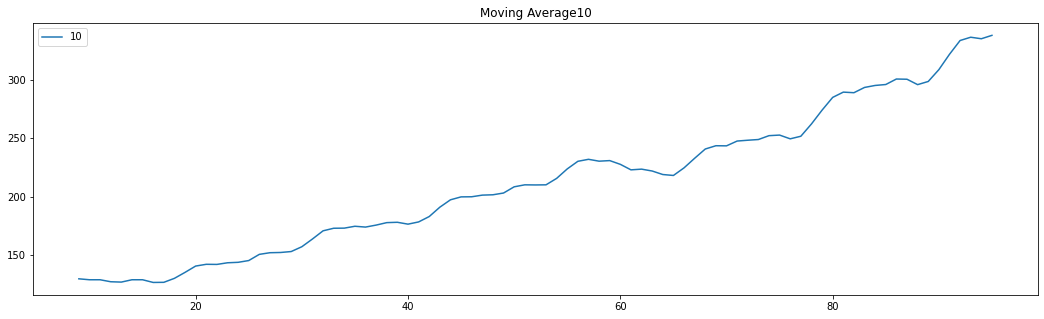

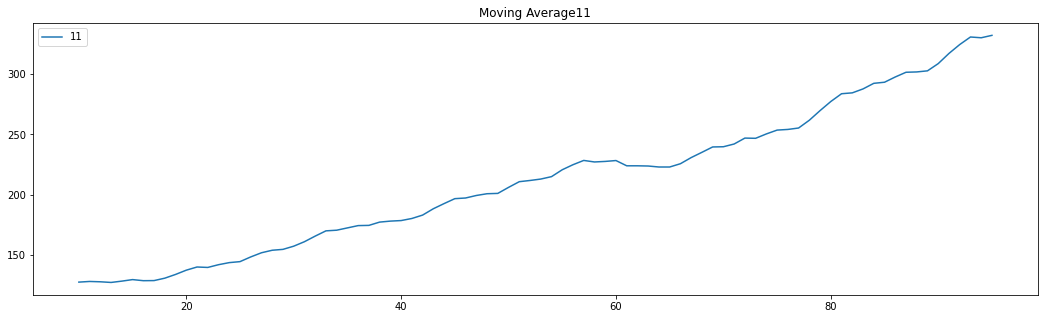

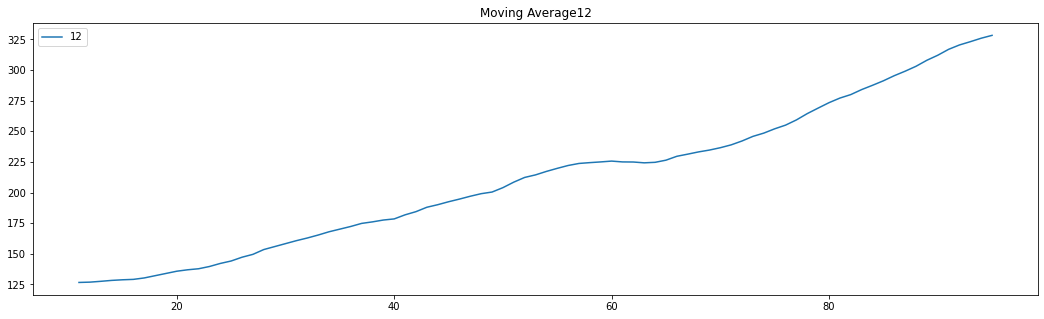

In [16]:
#Moving Average
plt.figure(figsize=(18,5))
air.Passengers.plot(label="org")
plt.title("Original Series")
for i in range(2,13):
    plt.figure(figsize=(18,5))
    air["Passengers"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average"+str(i))
    plt.legend(loc='best')
    plt.show()

Now the Decomposition of the data has to be done because it is used in Time-Series Forecasting to decompose the data into 3 things;

(Trend, Seasonality & Noise)

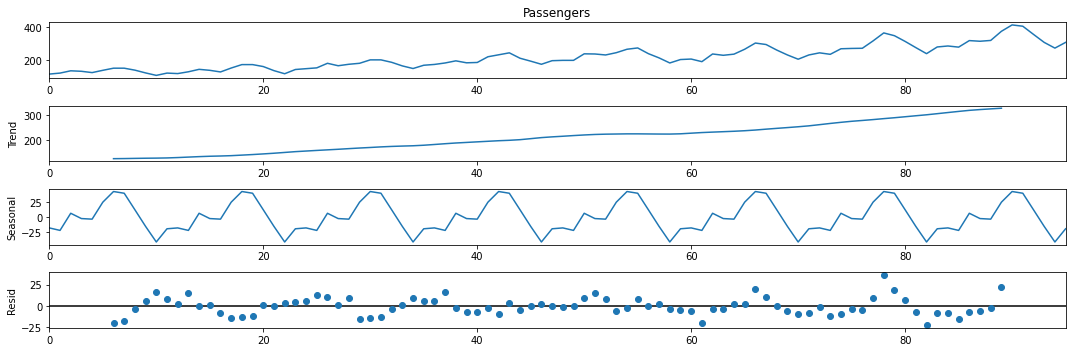

In [41]:
from statsmodels.tsa.seasonal import seasonal_decompose 

decompose_ts_add=seasonal_decompose(air.Passengers,period=12)
decompose_ts_add.plot()
plt.show()

**Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)**
The ACF and PACF are used to figure out the order of AR, MA, and ARMA models.

**Autocorrelation Function (ACF)**

Autocorrelation is the correlation between a time series with a lagged version of itself. The ACF starts at a lag of 0, which is the correlation of the time series with itself and therefore results in a correlation of 1.

**Partial Autocorrelation Function (PACF)**

The partial autocorrelation at lag k is the autocorrelation between X_t_t and X_(t-k) that is not accounted for by lags 1 through 𝑘−1.

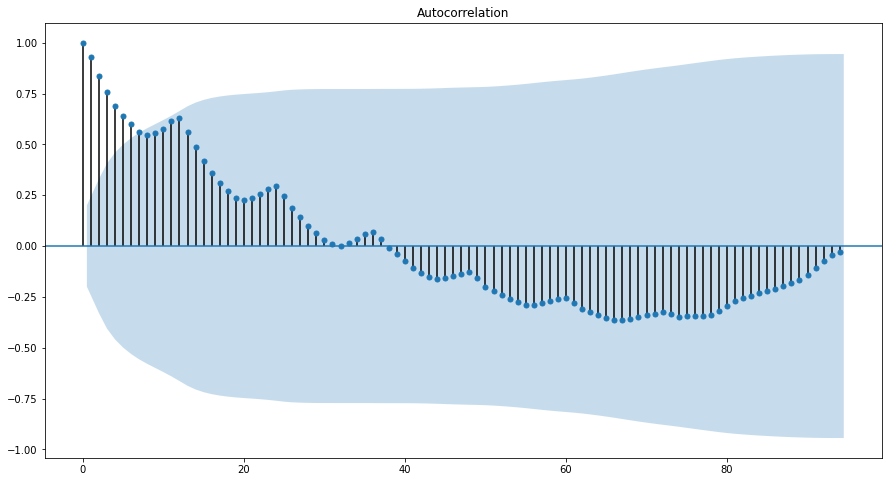

In [18]:
import statsmodels.graphics.tsaplots as tsa_plots
plt.rc("figure",figsize=(15,8)) 
tsa_plots.plot_acf(air.Passengers,lags=94)
plt.show()

Since the signal is always perfectly correlated with itself, ACF is always equal to 1 at lag 0.

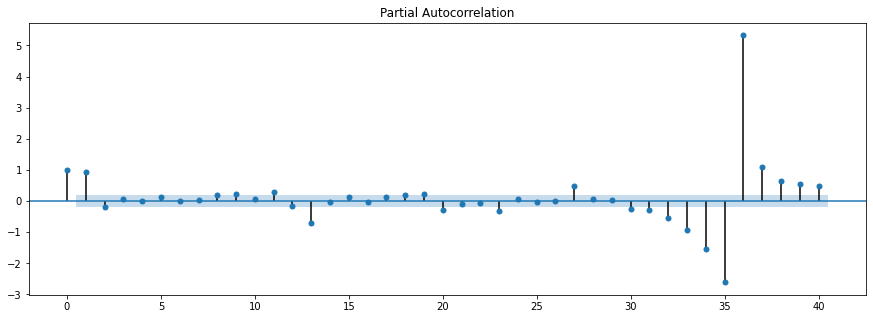

In [19]:
plt.rc("figure",figsize=(15,5))
tsa_plots.plot_pacf(air.Passengers,lags=40)
plt.show()

**Forecasting**

**Model Based Method**

In [20]:
Train=air1.head(72)
Test=air1.head(24)

In [21]:
#Linear Model
import statsmodels.formula.api as smf 

linear_model=smf.ols('Passengers~t',data=Train).fit()
pred_linear=pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear=np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_linear))**2))
rmse_linear

17.430512731005297

In [22]:
#Exponential Model
Exp=smf.ols('log_passengers~t',data=Train).fit()
pred_Exp=pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp=np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

16.477222826202564

In [23]:
#Quadratic
Quad = smf.ols('Passengers~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_Quad))**2))
rmse_Quad

17.460891564808936

In [24]:
#Additive Seasonality
add_sea = smf.ols('Passengers ~ month_Apr + month_Aug+  month_Dec+ month_Feb+  month_Jan+  month_Jul+ month_Jun+  month_Mar+  month_May+  month_Nov+  month_Oct+ month_Sep',  data=Train).fit()

pred_add_sea = pd.Series(add_sea.predict(Test[[ 'month_Apr',
       'month_Aug', 'month_Dec', 'month_Feb', 'month_Jan', 'month_Jul',
       'month_Jun', 'month_Mar', 'month_May', 'month_Nov', 'month_Oct',
       'month_Sep']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea))**2))
rmse_add_sea

50.736040773136125

In [25]:
#Additive Quadratic Seasonality
add_sea_Quad = smf.ols('Passengers ~t +t_squared + month_Apr + month_Aug+  month_Dec+ month_Feb+  month_Jan+  month_Jul+ month_Jun+  month_Mar+  month_May+  month_Nov+  month_Oct+ month_Sep',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['month_Apr',
       'month_Aug', 'month_Dec', 'month_Feb', 'month_Jan', 'month_Jul',
       'month_Jun', 'month_Mar', 'month_May', 'month_Nov', 'month_Oct',
       'month_Sep','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

9.415539860933656

In [26]:
#Multiplicative Seasonality
Mul_sea = smf.ols('log_passengers ~ month_Apr + month_Aug+  month_Dec+ month_Feb+  month_Jan+  month_Jul+ month_Jun+  month_Mar+  month_May+  month_Nov+  month_Oct+ month_Sep',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

45.78526360120413

In [27]:
#Multiplicative Additive Seasonality
Mul_Add_sea = smf.ols('log_passengers ~ t+ month_Apr + month_Aug+  month_Dec+ month_Feb+  month_Jan+  month_Jul+ month_Jun+  month_Mar+  month_May+  month_Nov+  month_Oct+ month_Sep',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea

45.78526360120413

Now comapare the results of each model

In [28]:
data={"MODEL":pd.Series(["linear","Exp","Quad","add_sea","add_sea_quad","Mult_sea","Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
4,add_sea_quad,9.415540
1,Exp,16.477223
0,linear,17.430513
2,Quad,17.460892
5,Mult_sea,45.785264
6,Mult_add_sea,45.785264
3,add_sea,50.736041


**Forecasting**

**Data Driven Method**

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing  
import math  
import sklearn.metrics  

def rmse(actual, pred):
    mse = sklearn.metrics.mean_squared_error(actual, pred)  
    rmse = math.sqrt(mse)
    return rmse 
# Simple Exponential Method
ses_model = SimpleExpSmoothing(Train["Passengers"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
rmse_ses = rmse(Test.Passengers, pred_ses) 
rmse_ses

17.040908930323816

In [30]:
#Holt's Method
hw_model = Holt(Train["Passengers"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
rmse_hw = rmse(Test.Passengers, pred_hw) 
rmse_hw

16.116639566779483

In [31]:
#Holt's Winter Exponential smoothing with additive seasonality and additive trend
hwe_model_add_add = ExponentialSmoothing(Train["Passengers"],seasonal="add",trend="add",seasonal_periods=4).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
rmse_hwe_add_add = rmse(Test.Passengers, pred_hwe_add_add)  
rmse_hwe_add_add

13.274953956744778

In [32]:
#Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_add = ExponentialSmoothing(Train["Passengers"],seasonal="mul",trend="add",seasonal_periods=4).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
rmse_mul_add =rmse(Test.Passengers, pred_hwe_mul_add) 
rmse_mul_add

13.218017244570424

Now compare the results.

In [33]:
data = {"MODEL":pd.Series(["linear","Exp","Quad","add_sea","add_sea_quad","Mult_sea","Mult_add_sea",'ses_model', 'hw_model', 'hwe_model_add_add', 'hwe_model_mul_add']),
        "RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea, rmse_ses, rmse_hw,rmse_hwe_add_add,rmse_mul_add  ])}
table_rmse=pd.DataFrame(data) 
table_rmse = table_rmse.sort_values(by=['RMSE_Values']) 
table_rmse

,MODEL,RMSE_Values
4,add_sea_quad,9.415540
10,hwe_model_mul_add,13.218017
9,hwe_model_add_add,13.274954
8,hw_model,16.116640
1,Exp,16.477223
7,ses_model,17.040909
0,linear,17.430513
2,Quad,17.460892
5,Mult_sea,45.785264
6,Mult_add_sea,45.785264


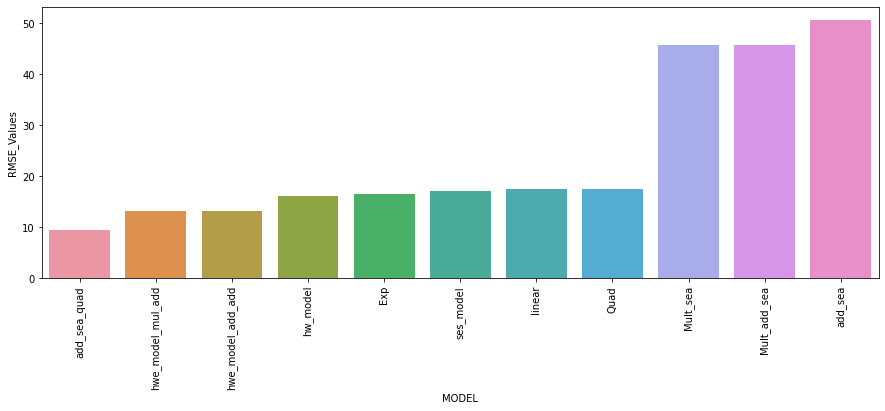

In [34]:
sns.barplot(table_rmse.MODEL,table_rmse.RMSE_Values)
plt.xticks(rotation=90)
plt.show()

Building final model by combining train & test based on Additive Seasonality Quadratic

In [35]:
add_sea_Quad = smf.ols('Passengers ~t +t_squared + month_Apr + month_Aug+  month_Dec+ month_Feb+  month_Jan+  month_Jul+ month_Jun+  month_Mar+  month_May+  month_Nov+  month_Oct+ month_Sep',data=air1).fit()
pred= add_sea_Quad.predict(air1.tail()) #predicting on historic data 
forecast_df = pd.DataFrame()

forecast_df['actual_passengers'] = air1.Passengers.tail()
forecast_df['Predicted_passengers'] = np.round(pred, 0)

forecast_df

,actual_passengers,Predicted_passengers
91,405,371.0
92,355,344.0
93,306,317.0
94,271,293.0
95,306,319.0


In [36]:
#Create new inputs for forecasting
new_df = pd.DataFrame() 
new_df['t'] = np.arange(97,109,1) 
new_df['t_squared'] = np.square(new_df.t)
new_df['month'] = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'] 
new_df = pd.get_dummies(new_df)
new_df.head()

,t,t_squared,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep
0,97,9409,0,0,0,0,1,0,0,0,0,0,0,0
1,98,9604,0,0,0,1,0,0,0,0,0,0,0,0
2,99,9801,0,0,0,0,0,0,0,1,0,0,0,0
3,100,10000,1,0,0,0,0,0,0,0,0,0,0,0
4,101,10201,0,0,0,0,0,0,0,0,1,0,0,0


In [37]:
#Creating dummy variables for 'month' feature
add_sea_Quad = smf.ols('Passengers ~t +t_squared + month_Apr + month_Aug+  month_Dec+ month_Feb+  month_Jan+  month_Jul+ month_Jun+  month_Mar+  month_May+  month_Nov+  month_Oct+ month_Sep',data=air1).fit()
pred= add_sea_Quad.predict(new_df) 

new_df['forcasted'] = pred

new_df

,t,t_squared,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,forcasted
0,97,9409,0,0,0,0,1,0,0,0,0,0,0,0,328.328687
1,98,9604,0,0,0,1,0,0,0,0,0,0,0,0,329.438178
2,99,9801,0,0,0,0,0,0,0,1,0,0,0,0,359.547668
3,100,10000,1,0,0,0,0,0,0,0,0,0,0,0,354.907159
4,101,10201,0,0,0,0,0,0,0,0,1,0,0,0,356.141650
5,102,10404,0,0,0,0,0,0,1,0,0,0,0,0,385.376141
6,103,10609,0,0,0,0,0,1,0,0,0,0,0,0,413.360631
7,104,10816,0,1,0,0,0,0,0,0,0,0,0,0,412.845122
8,105,11025,0,0,0,0,0,0,0,0,0,0,0,1,385.829613
9,106,11236,0,0,0,0,0,0,0,0,0,0,1,0,358.939103


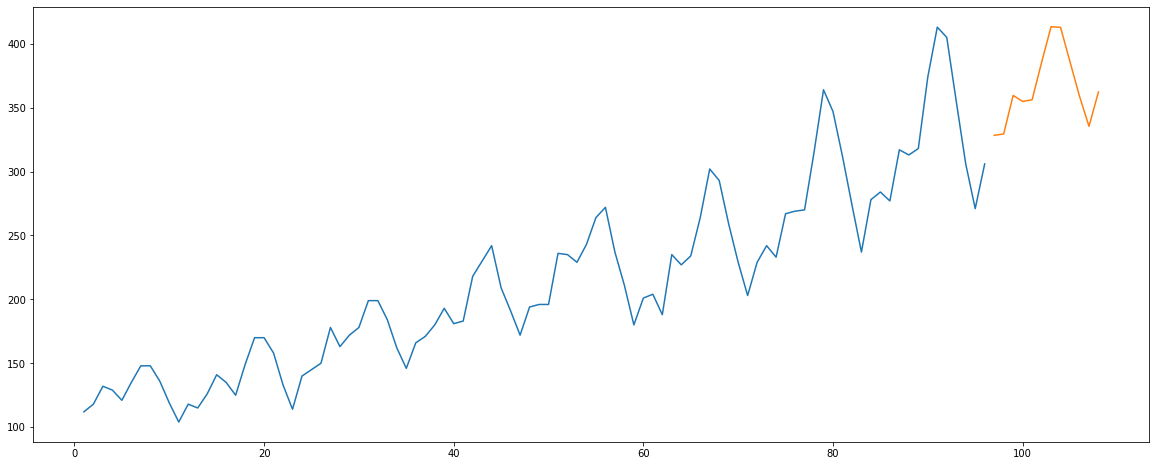

In [38]:
plt.figure(figsize=(20,8))
plt.plot(air1.t,air1.Passengers);
plt.plot(new_df.t,new_df.forcasted);